# Import Libraries and Code

In [1]:
import matplotlib
import sys

import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from PIL import Image
from scipy import ndimage, interpolate, optimize
from skimage.feature import peak_local_max

# Import custom libraries for this notebook
indir='/Path/To/Repository/'
if indir+'Code' not in sys.path: sys.path.append(indir+'Code')
import CNT_Analysis_Functions as CNT_F

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Set Figure rcParams

In [2]:
plt.rcParams['lines.linewidth']=0.75
plt.rcParams['image.cmap']='gist_gray'
plt.rcParams['font.size']=7
plt.rcParams['ytick.major.size']=2
plt.rcParams['xtick.major.size']=2
plt.rcParams['ytick.major.pad']=0.5
plt.rcParams['xtick.major.pad']=0.5
plt.rcParams['axes.labelpad']=1
plt.rcParams['figure.subplot.wspace']=0.3
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Arial'] 
plt.rcParams['mathtext.fontset']='custom'  
plt.rcParams['mathtext.rm']='Arial'      
plt.rcParams['mathtext.it']='Arial:italic' 
plt.rcParams['mathtext.bf']='Arial:bold' 

# Load and Process vEEL Spectra

## Load Point Spectra

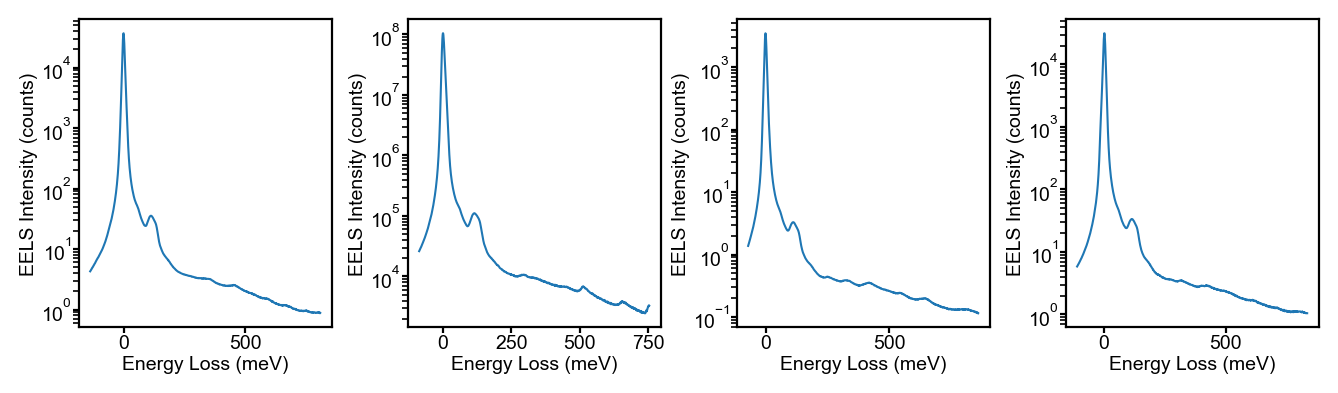

In [3]:
#Load Processed Datasets

filename=indir+'Data/vEEL_Point_Spectra/FilledCNT_1pt4nm_RT'
vEELS_1pt4_RT_E=np.load(filename+'_E.npy')
vEELS_1pt4_RT_S=np.load(filename+'_S.npy')

filename=indir+'Data/vEEL_Point_Spectra/FilledCNT_1pt4nm_Cryo'
vEELS_1pt4_CT_E=np.load(filename+'_E.npy')
vEELS_1pt4_CT_S=np.load(filename+'_S.npy')

filename=indir+'Data/vEEL_Point_Spectra/FilledCNT_2pt3nm_RT'
vEELS_2pt3_RT_E=np.load(filename+'_E.npy')
vEELS_2pt3_RT_S=np.load(filename+'_S.npy')

filename=indir+'Data/vEEL_Point_Spectra/FilledCNT_2pt3nm_Cryo'
vEELS_2pt3_CT_E=np.load(filename+'_E.npy')
vEELS_2pt3_CT_S=np.load(filename+'_S.npy')

f,a=plt.subplots(1,4,dpi=200,figsize=(8,2))
plt.setp(a,xlabel='Energy Loss (meV)',ylabel='EELS Intensity (counts)')
a[0].plot(vEELS_1pt4_RT_E*1000,vEELS_1pt4_RT_S)
a[0].set_yscale('log')
a[1].plot(vEELS_1pt4_CT_E*1000,vEELS_1pt4_CT_S)
a[1].set_yscale('log')
a[2].plot(vEELS_2pt3_RT_E*1000,vEELS_2pt3_RT_S)
a[2].set_yscale('log')
a[3].plot(vEELS_2pt3_CT_E*1000,vEELS_2pt3_CT_S)
a[3].set_yscale('log')

## Fit Background to Extract O-H Peak

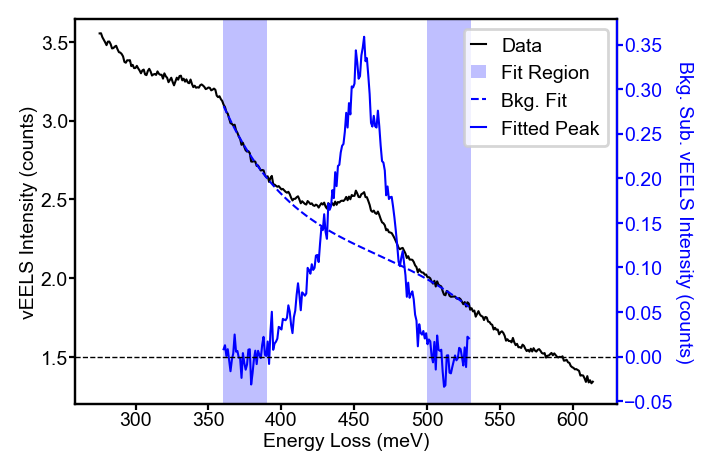

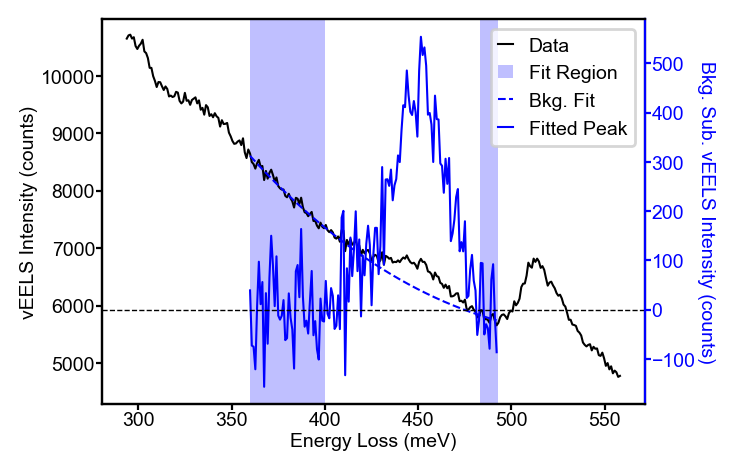

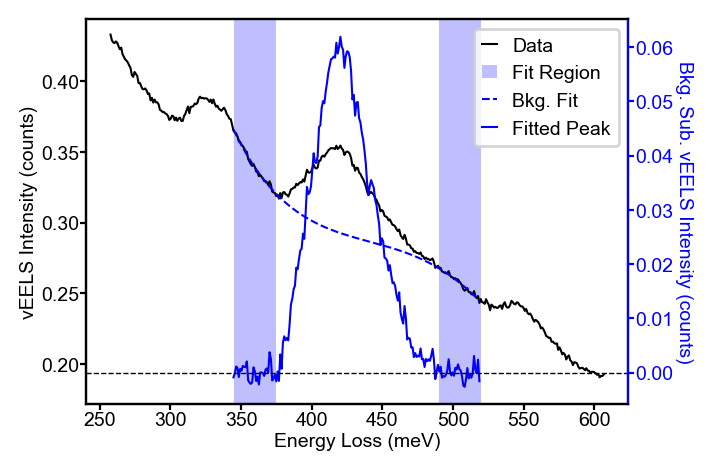

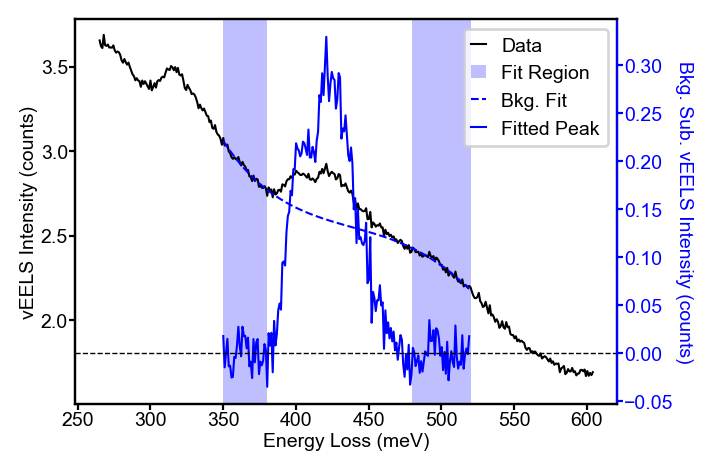

In [4]:
# Define Fit Regions (1.4 nm CNT, Room Temperature)
R1_1pt4_RT=360,390
R2_1pt4_RT=500,530

# Perform Fit
vEELS_1pt4_RT_E_f,vEELS_1pt4_RT_S_f=CNT_F.GetExponentialFit_2R(vEELS_1pt4_RT_E*1000, vEELS_1pt4_RT_S, 3, R1_1pt4_RT, R2_1pt4_RT)

# Define Fit Regions (1.4 nm CNT, Cryo Temperature)
R1_1pt4_CT=360,400
R2_1pt4_CT=483,493

# Perform Fit
vEELS_1pt4_CT_E_f,vEELS_1pt4_CT_S_f=CNT_F.GetExponentialFit_2R(vEELS_1pt4_CT_E*1000, vEELS_1pt4_CT_S, 3, R1_1pt4_CT, R2_1pt4_CT)

# Define Fit Regions (2.3 nm CNT, Room Temperature)
R1_2pt3_RT=345,375
R2_2pt3_RT=490,520

# Perform Fit
vEELS_2pt3_RT_E_f,vEELS_2pt3_RT_S_f=CNT_F.GetExponentialFit_2R(vEELS_2pt3_RT_E*1000, vEELS_2pt3_RT_S, 3, R1_2pt3_RT, R2_2pt3_RT)

# Define Fit Regions (2.3 nm CNT, Cryo Temperature)
R1_2pt3_CT=350,380
R2_2pt3_CT=480,520
# Perform Fit
vEELS_2pt3_CT_E_f,vEELS_2pt3_CT_S_f=CNT_F.GetExponentialFit_2R(vEELS_2pt3_CT_E*1000, vEELS_2pt3_CT_S, 3, R1_2pt3_CT, R2_2pt3_CT)

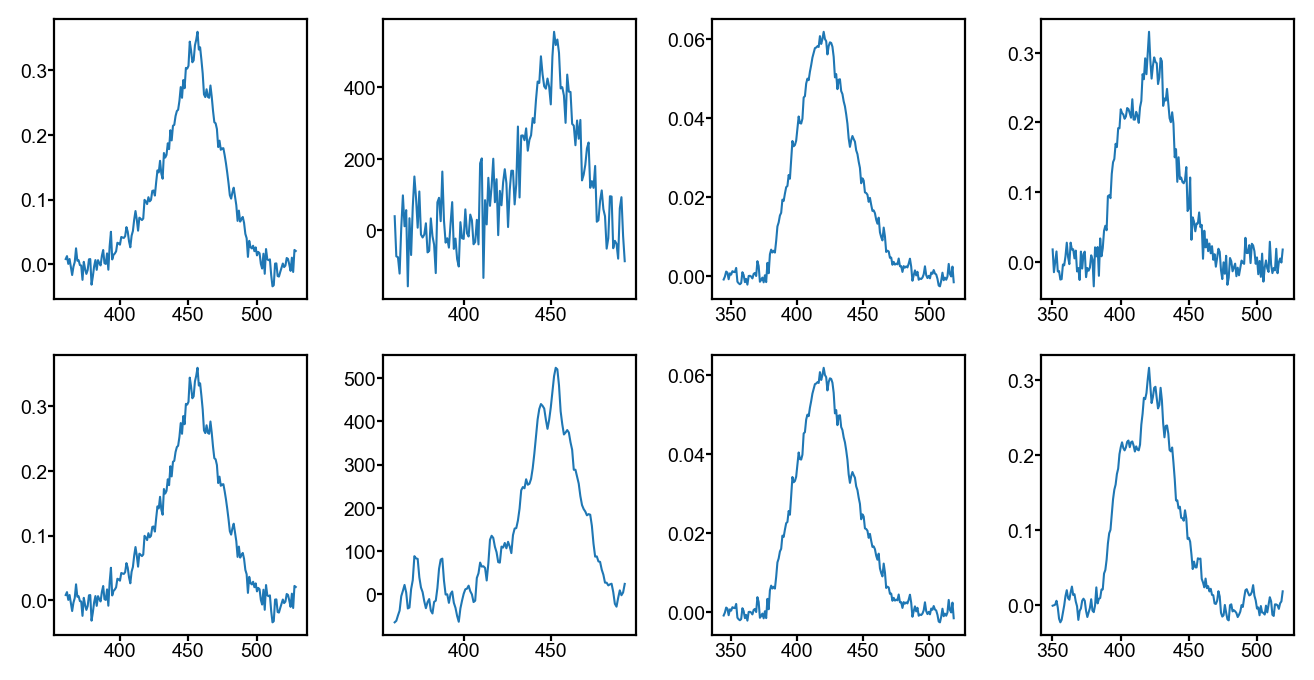

In [5]:
## Savitky Golay Filter Spectra to Match SNR As Close As Possible Between Spectra

vEELS_E=[vEELS_1pt4_RT_E_f,vEELS_1pt4_CT_E_f,vEELS_2pt3_RT_E_f,vEELS_2pt3_CT_E_f]
vEELS_S=[vEELS_1pt4_RT_S_f,vEELS_1pt4_CT_S_f,vEELS_2pt3_RT_S_f,vEELS_2pt3_CT_S_f]

SG_Windows=[0,9,0,5]
vEELS_S_SG=[]

for S,W in zip(vEELS_S,SG_Windows):
    if W==0: vEELS_S_SG.append(S); continue
    S_Smooth=CNT_F.GetFilteredSpectrum(S,W,3)
    vEELS_S_SG.append(S_Smooth)

f,a=plt.subplots(2,4,figsize=(8,4),dpi=200)
for i in range(4):
    a[0,i].plot(vEELS_E[i],vEELS_S[i])
    a[1,i].plot(vEELS_E[i],vEELS_S_SG[i])

# Load and Process DFT vDOS

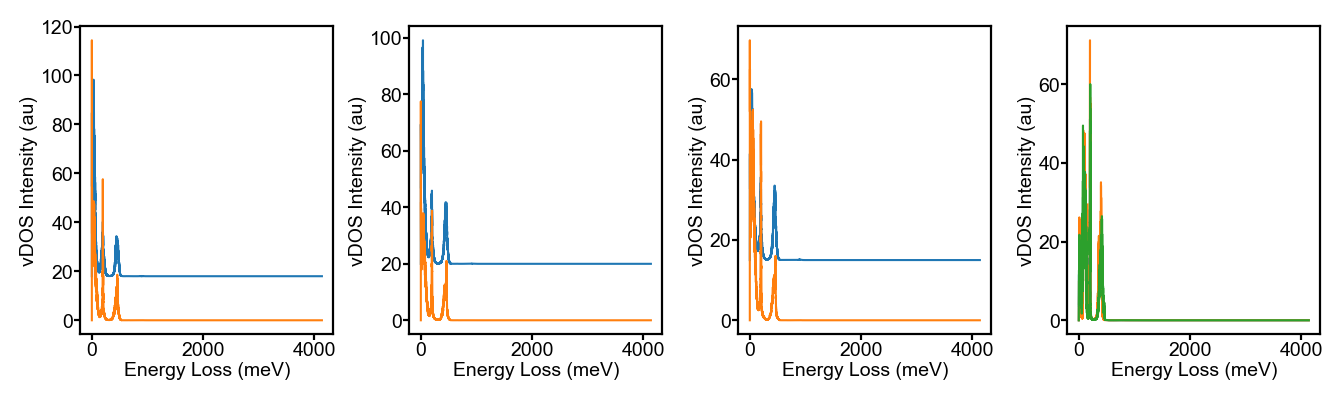

In [6]:
# Load vDOS from MD Simulations

filename=indir+'Data/DFT_vDOS/vCNT_AllT_0pt5_vDOS.csv'
vDOS_0pt5_df=pd.read_csv(filename)
vDOS_0pt5_keys=vDOS_0pt5_df.keys()

filename=indir+'Data/DFT_vDOS/vCNT_AllT_pt75_vDOS.csv'
vDOS_0pt75_df=pd.read_csv(filename)
vDOS_0pt75_keys=vDOS_0pt75_df.keys()

filename=indir+'Data/DFT_vDOS/vCNT_AllT_1pt0_vDOS.csv'
vDOS_1pt0_df=pd.read_csv(filename)
vDOS_1pt0_keys=vDOS_1pt0_df.keys()

filename=indir+'Data/DFT_vDOS/MixedPhaseIce_vDOS.csv'
vDOS_Ice_df=pd.read_csv(filename)
vDOS_Ice_keys=vDOS_Ice_df.keys()

vDOS_0pt5_RT_E,vDOS_0pt5_RT_S=vDOS_0pt5_df[vDOS_0pt5_keys[1]],vDOS_0pt5_df[vDOS_0pt5_keys[2]]
vDOS_0pt5_CT_E,vDOS_0pt5_CT_S=vDOS_0pt5_df[vDOS_0pt5_keys[4]],vDOS_0pt5_df[vDOS_0pt5_keys[5]]

vDOS_0pt75_RT_E,vDOS_0pt75_RT_S=vDOS_0pt75_df[vDOS_0pt75_keys[1]],vDOS_0pt75_df[vDOS_0pt75_keys[2]]
vDOS_0pt75_CT_E,vDOS_0pt75_CT_S=vDOS_0pt75_df[vDOS_0pt75_keys[4]],vDOS_0pt75_df[vDOS_0pt75_keys[5]]

vDOS_1pt0_RT_E,vDOS_1pt0_RT_S=vDOS_1pt0_df[vDOS_1pt0_keys[1]],vDOS_1pt0_df[vDOS_1pt0_keys[2]]
vDOS_1pt0_CT_E,vDOS_1pt0_CT_S=vDOS_1pt0_df[vDOS_1pt0_keys[4]],vDOS_1pt0_df[vDOS_1pt0_keys[5]]

vDOS_Ice_Total_E,vDOS_Ice_Total_S=vDOS_Ice_df[vDOS_Ice_keys[1]],vDOS_Ice_df[vDOS_Ice_keys[2]]
vDOS_Ice_Crystal_E,vDOS_Ice_Crystal_S=vDOS_Ice_df[vDOS_Ice_keys[4]],vDOS_Ice_df[vDOS_Ice_keys[5]]
vDOS_Ice_Amorphous_E,vDOS_Ice_Amorphous_S=vDOS_Ice_df[vDOS_Ice_keys[7]],vDOS_Ice_df[vDOS_Ice_keys[8]]

f,a=plt.subplots(1,4,dpi=200,figsize=(8,2))
plt.setp(a, xlabel='Energy Loss (meV)', ylabel='vDOS Intensity (au)')
a[0].plot(vDOS_0pt5_RT_E,vDOS_0pt5_RT_S)
a[0].plot(vDOS_0pt5_CT_E,vDOS_0pt5_CT_S)
a[1].plot(vDOS_0pt75_RT_E,vDOS_0pt75_RT_S)
a[1].plot(vDOS_0pt75_CT_E,vDOS_0pt75_CT_S)
a[2].plot(vDOS_1pt0_RT_E,vDOS_1pt0_RT_S)
a[2].plot(vDOS_1pt0_CT_E,vDOS_1pt0_CT_S)
a[3].plot(vDOS_Ice_Total_E,vDOS_Ice_Total_S)
a[3].plot(vDOS_Ice_Crystal_E,vDOS_Ice_Crystal_S)
a[3].plot(vDOS_Ice_Amorphous_E,vDOS_Ice_Amorphous_S)

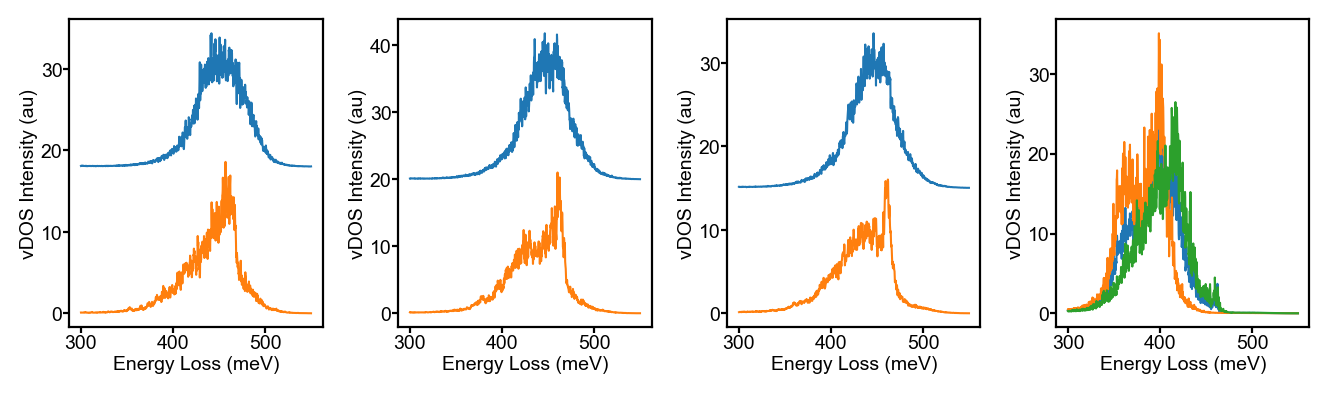

In [7]:
# Cut down vDOS to O-H stretch regime
en_lo=300; en_hi=550

i1,i2=CNT_F.Get_i(vDOS_0pt5_RT_E,en_lo),CNT_F.Get_i(vDOS_0pt5_RT_E,en_hi)
vDOS_0pt5_RT_E=vDOS_0pt5_RT_E[i1:i2]; vDOS_0pt5_RT_S=vDOS_0pt5_RT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_0pt5_CT_E,en_lo),CNT_F.Get_i(vDOS_0pt5_CT_E,en_hi)
vDOS_0pt5_CT_E=vDOS_0pt5_CT_E[i1:i2]; vDOS_0pt5_CT_S=vDOS_0pt5_CT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_0pt75_RT_E,en_lo),CNT_F.Get_i(vDOS_0pt75_RT_E,en_hi)
vDOS_0pt75_RT_E=vDOS_0pt75_RT_E[i1:i2]; vDOS_0pt75_RT_S=vDOS_0pt75_RT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_0pt75_CT_E,en_lo),CNT_F.Get_i(vDOS_0pt75_CT_E,en_hi)
vDOS_0pt75_CT_E=vDOS_0pt75_CT_E[i1:i2]; vDOS_0pt75_CT_S=vDOS_0pt75_CT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_1pt0_RT_E,en_lo),CNT_F.Get_i(vDOS_1pt0_RT_E,en_hi)
vDOS_1pt0_RT_E=vDOS_1pt0_RT_E[i1:i2]; vDOS_1pt0_RT_S=vDOS_1pt0_RT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_1pt0_CT_E,en_lo),CNT_F.Get_i(vDOS_1pt0_CT_E,en_hi)
vDOS_1pt0_CT_E=vDOS_1pt0_CT_E[i1:i2]; vDOS_1pt0_CT_S=vDOS_1pt0_CT_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_Ice_Total_E,en_lo),CNT_F.Get_i(vDOS_Ice_Total_E,en_hi)
vDOS_Ice_Total_E=vDOS_Ice_Total_E[i1:i2]; vDOS_Ice_Total_S=vDOS_Ice_Total_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_Ice_Crystal_E,en_lo),CNT_F.Get_i(vDOS_Ice_Crystal_E,en_hi)
vDOS_Ice_Crystal_E=vDOS_Ice_Crystal_E[i1:i2]; vDOS_Ice_Crystal_S=vDOS_Ice_Crystal_S[i1:i2]

i1,i2=CNT_F.Get_i(vDOS_Ice_Amorphous_E,en_lo),CNT_F.Get_i(vDOS_Ice_Amorphous_E,en_hi)
vDOS_Ice_Amorphous_E=vDOS_Ice_Amorphous_E[i1:i2]; vDOS_Ice_Amorphous_S=vDOS_Ice_Amorphous_S[i1:i2]

f,a=plt.subplots(1,4,dpi=200,figsize=(8,2))
plt.setp(a, xlabel='Energy Loss (meV)', ylabel='vDOS Intensity (au)')
a[0].plot(vDOS_0pt5_RT_E,vDOS_0pt5_RT_S)
a[0].plot(vDOS_0pt5_CT_E,vDOS_0pt5_CT_S)
a[1].plot(vDOS_0pt75_RT_E,vDOS_0pt75_RT_S)
a[1].plot(vDOS_0pt75_CT_E,vDOS_0pt75_CT_S)
a[2].plot(vDOS_1pt0_RT_E,vDOS_1pt0_RT_S)
a[2].plot(vDOS_1pt0_CT_E,vDOS_1pt0_CT_S)
a[3].plot(vDOS_Ice_Total_E,vDOS_Ice_Total_S)
a[3].plot(vDOS_Ice_Crystal_E,vDOS_Ice_Crystal_S)
a[3].plot(vDOS_Ice_Amorphous_E,vDOS_Ice_Amorphous_S)

# Load and Process Mixed Ice Snapshot

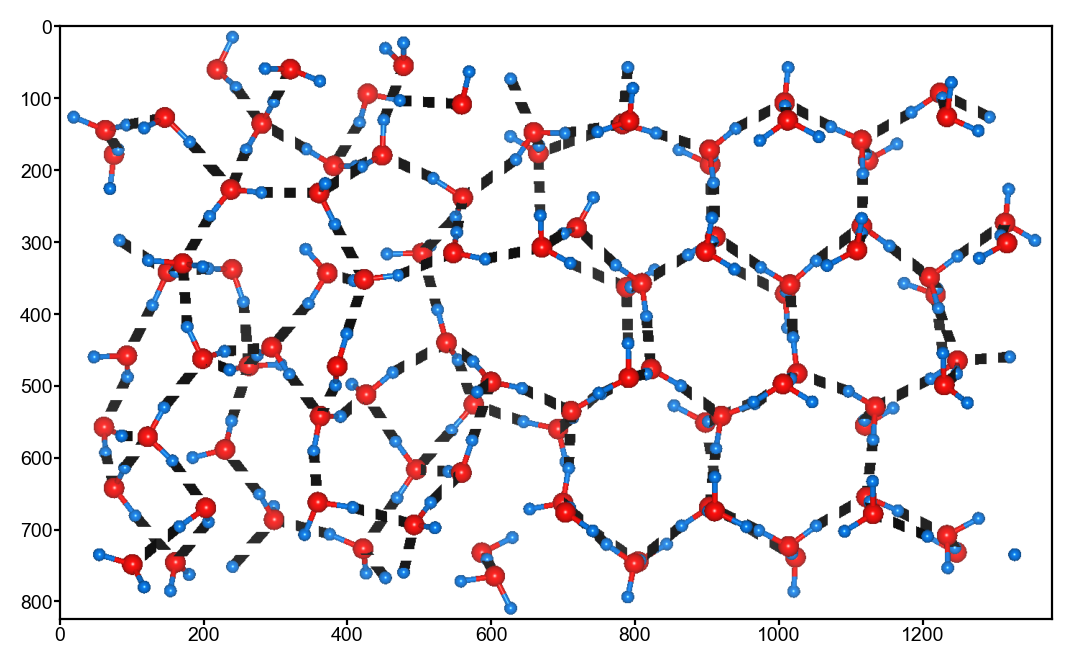

In [8]:
# Load TIF Image
# Note: .cif files handled in vesta and exported as raster image
filename=indir+'Data/DFT_Snapshots/MixedPhaseIce_snapshot.tif'
Snapshot_Ice=Image.open(filename,'r')

Snapshot_Ice=Snapshot_Ice.crop((825,0,1650,1380))
Snapshot_Ice=Snapshot_Ice.transpose(Image.Transpose.TRANSPOSE)

fig=plt.figure(dpi=200)
plt.imshow(Snapshot_Ice)

# Figure

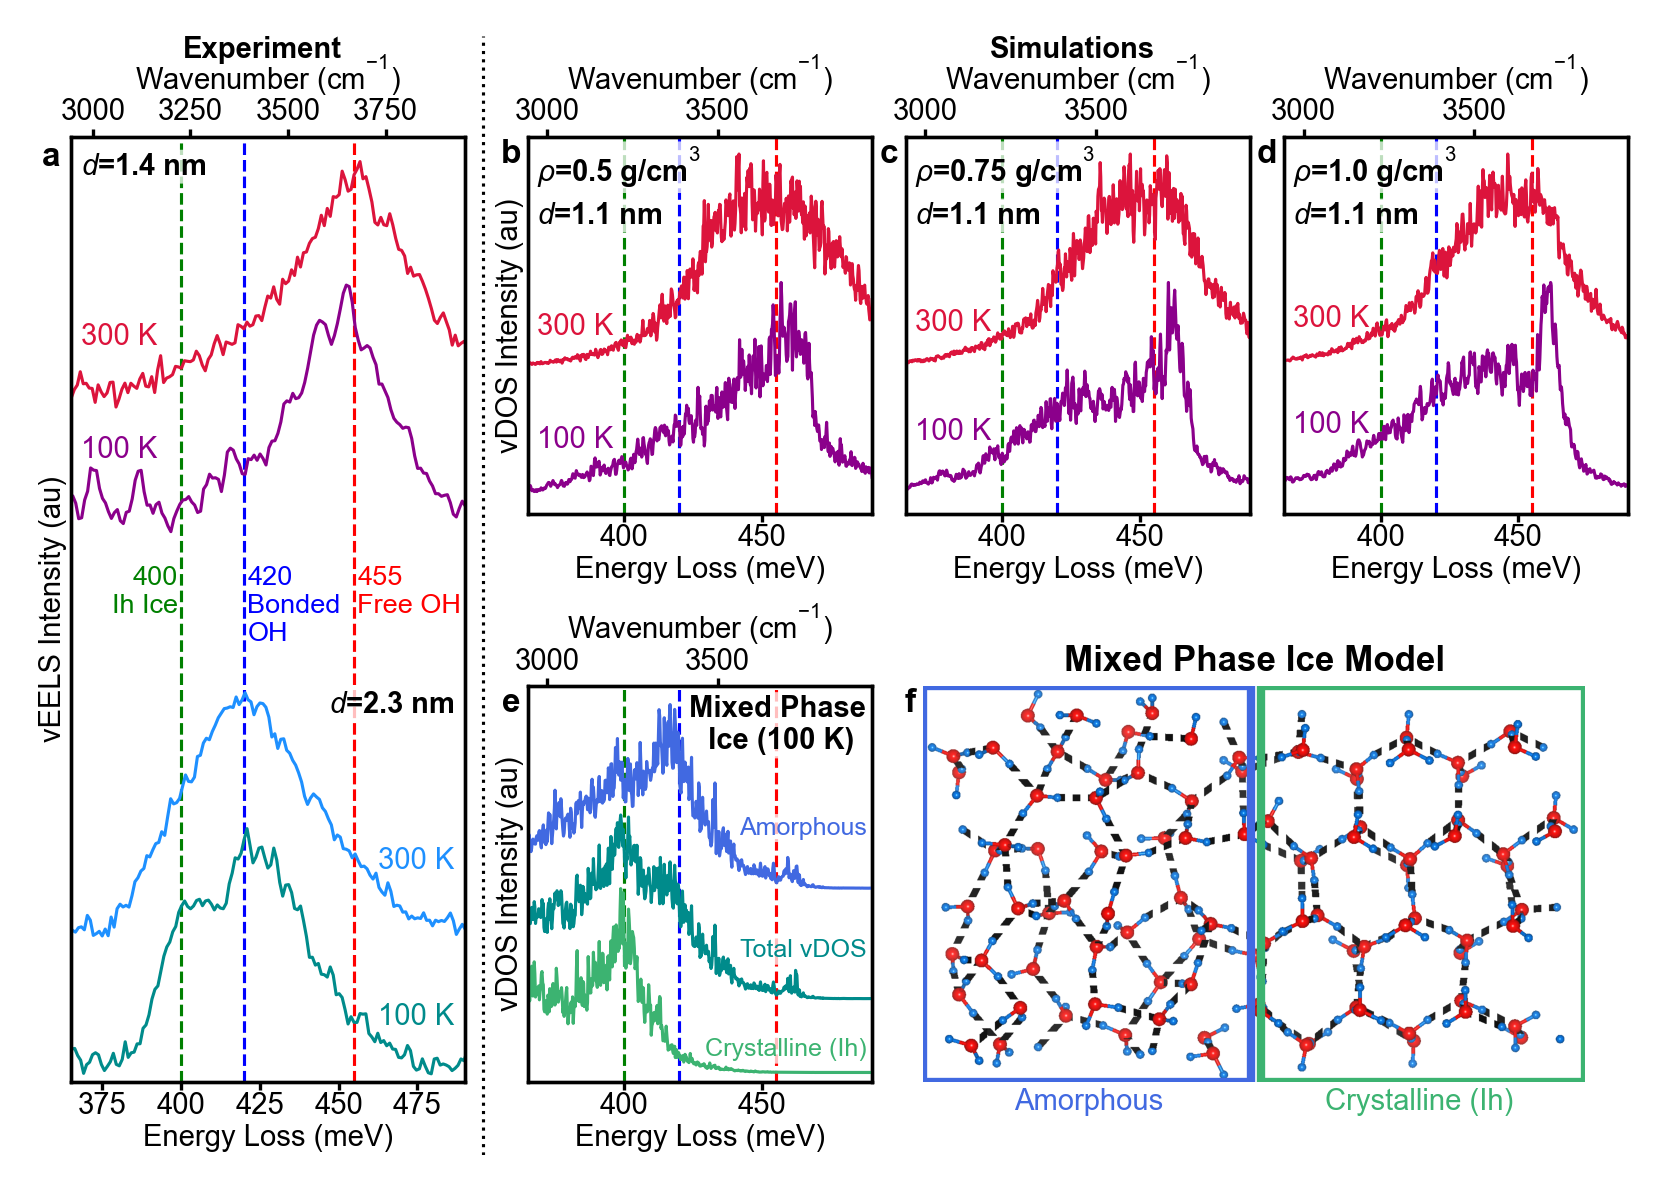

In [9]:
fig=plt.figure(dpi=300,figsize=(136/25.4,3.75))

# Preamble: Experimental and Theoretical Sides of Figure
ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
for spine in ax.spines.values(): spine.set_visible(False)

ax.axvline(0.282,0,0.995,color='k',ls=':')
ax.text(0.095,0.995,'Experiment',fontweight='bold',ha='left',va='top',color='k',transform=ax.transAxes)
ax.text(0.5975,0.995,'Simulations',fontweight='bold',ha='left',va='top',color='k',transform=ax.transAxes)

# Panel a: vEELS RT and CT
ax_vEELS=fig.add_axes([0.0255,0.065,0.245,0.84])
plt.setp(ax_vEELS,xlim=(365,490),ylim=(-0.025,3.8),xticks=[375,400,425,450,475],yticks=[]
         ,xlabel='Energy Loss (meV)',ylabel='vEELS Intensity (au)')
ax_vEELS.plot(vEELS_E[0],CNT_F.NormArray(vEELS_S_SG[0])+2.7,lw=0.75,color='Crimson')
ax_vEELS.plot(vEELS_E[1],CNT_F.NormArray(vEELS_S_SG[1])+2.2,lw=0.75,color='DarkMagenta')
ax_vEELS.plot(vEELS_E[2],CNT_F.NormArray(vEELS_S_SG[2])+0.55,lw=0.75,color='DodgerBlue')
ax_vEELS.plot(vEELS_E[3],CNT_F.NormArray(vEELS_S_SG[3]),lw=0.75,color='DarkCyan')

ax_vEELS.axvline(400,color='g',ls='--',zorder=0)
ax_vEELS.text(399,np.mean(ax_vEELS.get_ylim())+0.175,'400\nIh Ice',ha='right',va='top',color='g',fontsize=6.5)
ax_vEELS.axvline(420,color='b',ls='--',zorder=0)
ax_vEELS.text(421,np.mean(ax_vEELS.get_ylim())+0.175,'420\nBonded\nOH',ha='left',va='top',color='b',fontsize=6.5)
ax_vEELS.axvline(455,color='r',ls='--',zorder=0)
ax_vEELS.text(456,np.mean(ax_vEELS.get_ylim())+0.175,'455\nFree OH',ha='left',va='top',color='r',fontsize=6.5)

bbox_dict=dict(boxstyle='round, pad=0.1',facecolor='w',edgecolor='none',alpha=0.75)
ax_vEELS.text(0.025,0.96,r'$d$=1.4 nm',fontweight='bold',color='k',ha='left',bbox=bbox_dict,transform=ax_vEELS.transAxes)
ax_vEELS.text(0.025,0.78,'300 K',color='Crimson',ha='left',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.025,0.66,'100 K',color='DarkMagenta',ha='left',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.975,0.39,r'$d$=2.3 nm',fontweight='bold',color='k',ha='right',bbox=bbox_dict,transform=ax_vEELS.transAxes)
ax_vEELS.text(0.975,0.225,'300 K',color='DodgerBlue',ha='right',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.975,0.06,'100 K',color='DarkCyan',ha='right',transform=ax_vEELS.transAxes)

a2=ax_vEELS.twiny()
a2.set_xticks([3000,3250,3500,3750])
a2.set_xlim(365*8.06554,490*8.06554)
a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

labels=['a','b','c','d','e','f']
label_kwargs={'fontsize':8,'fontweight':'bold','ha':'center','va':'top'}
ax_vEELS.text(-0.05,0.995,labels.pop(0),transform=ax_vEELS.transAxes,**label_kwargs)

# Panel b-d: vDOS at RT and CT for Water-Filled CNT
gs_vDOS_CNT=plt.GridSpec(ncols=3,nrows=1,hspace=0,wspace=0.1,top=0.905,bottom=0.57,right=0.995,left=0.31)
a_vDOS_CNT=np.asarray([fig.add_subplot(gs_vDOS_CNT[i]) for i in range(3)])
plt.setp(a_vDOS_CNT,xlim=(365,490),yticks=[],xlabel='Energy Loss (meV)')
a_vDOS_CNT[0].plot(vDOS_0pt5_RT_E,CNT_F.NormArray(vDOS_0pt5_RT_S)+0.6,color='Crimson',zorder=1000)
a_vDOS_CNT[0].plot(vDOS_0pt5_CT_E,CNT_F.NormArray(vDOS_0pt5_CT_S),color='DarkMagenta',zorder=1000)
a_vDOS_CNT[1].plot(vDOS_0pt75_RT_E,CNT_F.NormArray(vDOS_0pt75_RT_S)+0.6,color='Crimson',zorder=1000)
a_vDOS_CNT[1].plot(vDOS_0pt75_CT_E,CNT_F.NormArray(vDOS_0pt75_CT_S),color='DarkMagenta',zorder=1000)
a_vDOS_CNT[2].plot(vDOS_1pt0_RT_E,CNT_F.NormArray(vDOS_1pt0_RT_S)+0.6,color='Crimson',zorder=1000)
a_vDOS_CNT[2].plot(vDOS_1pt0_CT_E,CNT_F.NormArray(vDOS_1pt0_CT_S),color='DarkMagenta',zorder=1000)

a_vDOS_CNT[0].set_ylabel('vDOS Intensity (au)')

dens=[r'$\rho$=0.5 g/cm$^3$',r'$\rho$=0.75 g/cm$^3$',r'$\rho$=1.0 g/cm$^3$']
for i in range(3):
    a_vDOS_CNT[i].text(-0.05,0.995,labels.pop(0),transform=a_vDOS_CNT[i].transAxes,**label_kwargs)
    a_vDOS_CNT[i].text(0.025,0.88,dens.pop(0),fontweight='bold',bbox=bbox_dict,transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.025,0.77,r'$d$=1.1 nm',fontweight='bold',bbox=bbox_dict,transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.025,0.475+i*0.01,'300 K',color='Crimson',transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.025,0.175+i*0.02,'100 K',color='DarkMagenta',transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].axvline(400,color='g',ls='--',zorder=0)
    a_vDOS_CNT[i].axvline(420,color='b',ls='--',zorder=0)
    a_vDOS_CNT[i].axvline(455,color='r',ls='--',zorder=0)
    a2=a_vDOS_CNT[i].twiny()
    a2.set_xlim(365*8.06554,490*8.06554)
    a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

# Panel e: Mixed Phase Ice vDOS
xy=a_vDOS_CNT[0].get_position()
a_vDOS_Ice=fig.add_axes([xy.x0,0.065,xy.width,xy.height*1.05],xlim=(365,490),ylim=(-0.05,2.1),yticks=[]
                        ,xlabel='Energy Loss (meV)',ylabel='vDOS Intensity (au)')
a_vDOS_Ice.plot(vDOS_Ice_Amorphous_E,CNT_F.NormArray(vDOS_Ice_Amorphous_S)+1.0,color='RoyalBlue',zorder=1000)
a_vDOS_Ice.plot(vDOS_Ice_Total_E,CNT_F.NormArray(vDOS_Ice_Total_S)+0.4,color='DarkCyan',zorder=1000)
a_vDOS_Ice.plot(vDOS_Ice_Crystal_E,CNT_F.NormArray(vDOS_Ice_Crystal_S),color='MediumSeaGreen',zorder=1000)

a_vDOS_Ice.text(0.725,0.84,'Mixed Phase\n Ice (100 K)',fontweight='bold',color='k'
                ,transform=a_vDOS_Ice.transAxes,ha='center',bbox=bbox_dict)

a_vDOS_Ice.text(0.985,0.625,'Amorphous',color='RoyalBlue',
                fontsize=6,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)
a_vDOS_Ice.text(0.985,0.315,'Total vDOS',color='DarkCyan',
                fontsize=6,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)
a_vDOS_Ice.text(0.985,0.065,'Crystalline (Ih)',color='MediumSeaGreen',
                fontsize=6,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)

a_vDOS_Ice.axvline(400,color='g',ls='--',zorder=0)
a_vDOS_Ice.axvline(420,color='b',ls='--',zorder=0)
a_vDOS_Ice.axvline(455,color='r',ls='--',zorder=0)

a2=a_vDOS_Ice.twiny()
a2.set_xlim(365*8.06554,490*8.06554)
a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

a_vDOS_Ice.text(-0.05,0.995,labels.pop(0),transform=a_vDOS_Ice.transAxes,**label_kwargs)

# Panel f: Mixed Phase Ice Snapshot
ax_snapshot=fig.add_axes([xy.x1,0.065,1-xy.x1,xy.height*1.05],xticks=[],yticks=[])
for spine in ax_snapshot.spines.values(): spine.set_edgecolor('None')
    
ax_snapshot.imshow(Snapshot_Ice)

ax_snapshot.set_title('Mixed Phase Ice Model',y=0.975,fontweight='bold')
ax_snapshot.add_patch(Rectangle((0.,0),0.495,1,fc='None',ec='RoyalBlue',lw=2,transform=ax_snapshot.transAxes))
ax_snapshot.text(0.25,-0.07,'Amorphous',color='RoyalBlue'
                ,transform=ax_snapshot.transAxes,ha='center',bbox=bbox_dict)

ax_snapshot.add_patch(Rectangle((0.51,0.0),0.49,1,fc='None',ec='MediumSeaGreen',lw=2,transform=ax_snapshot.transAxes))
ax_snapshot.text(0.75,-0.07,'Crystalline (Ih)',color='MediumSeaGreen'
                ,transform=ax_snapshot.transAxes,ha='center',bbox=bbox_dict)

ax_snapshot.text(-0.02,0.995,labels.pop(0),transform=ax_snapshot.transAxes,**label_kwargs)

fig.savefig('/Users/j6h/TheRepository/Analyses/Majumdar-Stanford/CNT_Paper_Final/Figures/Figure3.pdf',format='pdf',bbox_inches='tight',dpi=600)
fig.savefig('/Users/j6h/TheRepository/Analyses/Majumdar-Stanford/CNT_Paper_Final/Figures/Figure3.png',dpi=300)

Text(-0.0175, 0.995, 'f')

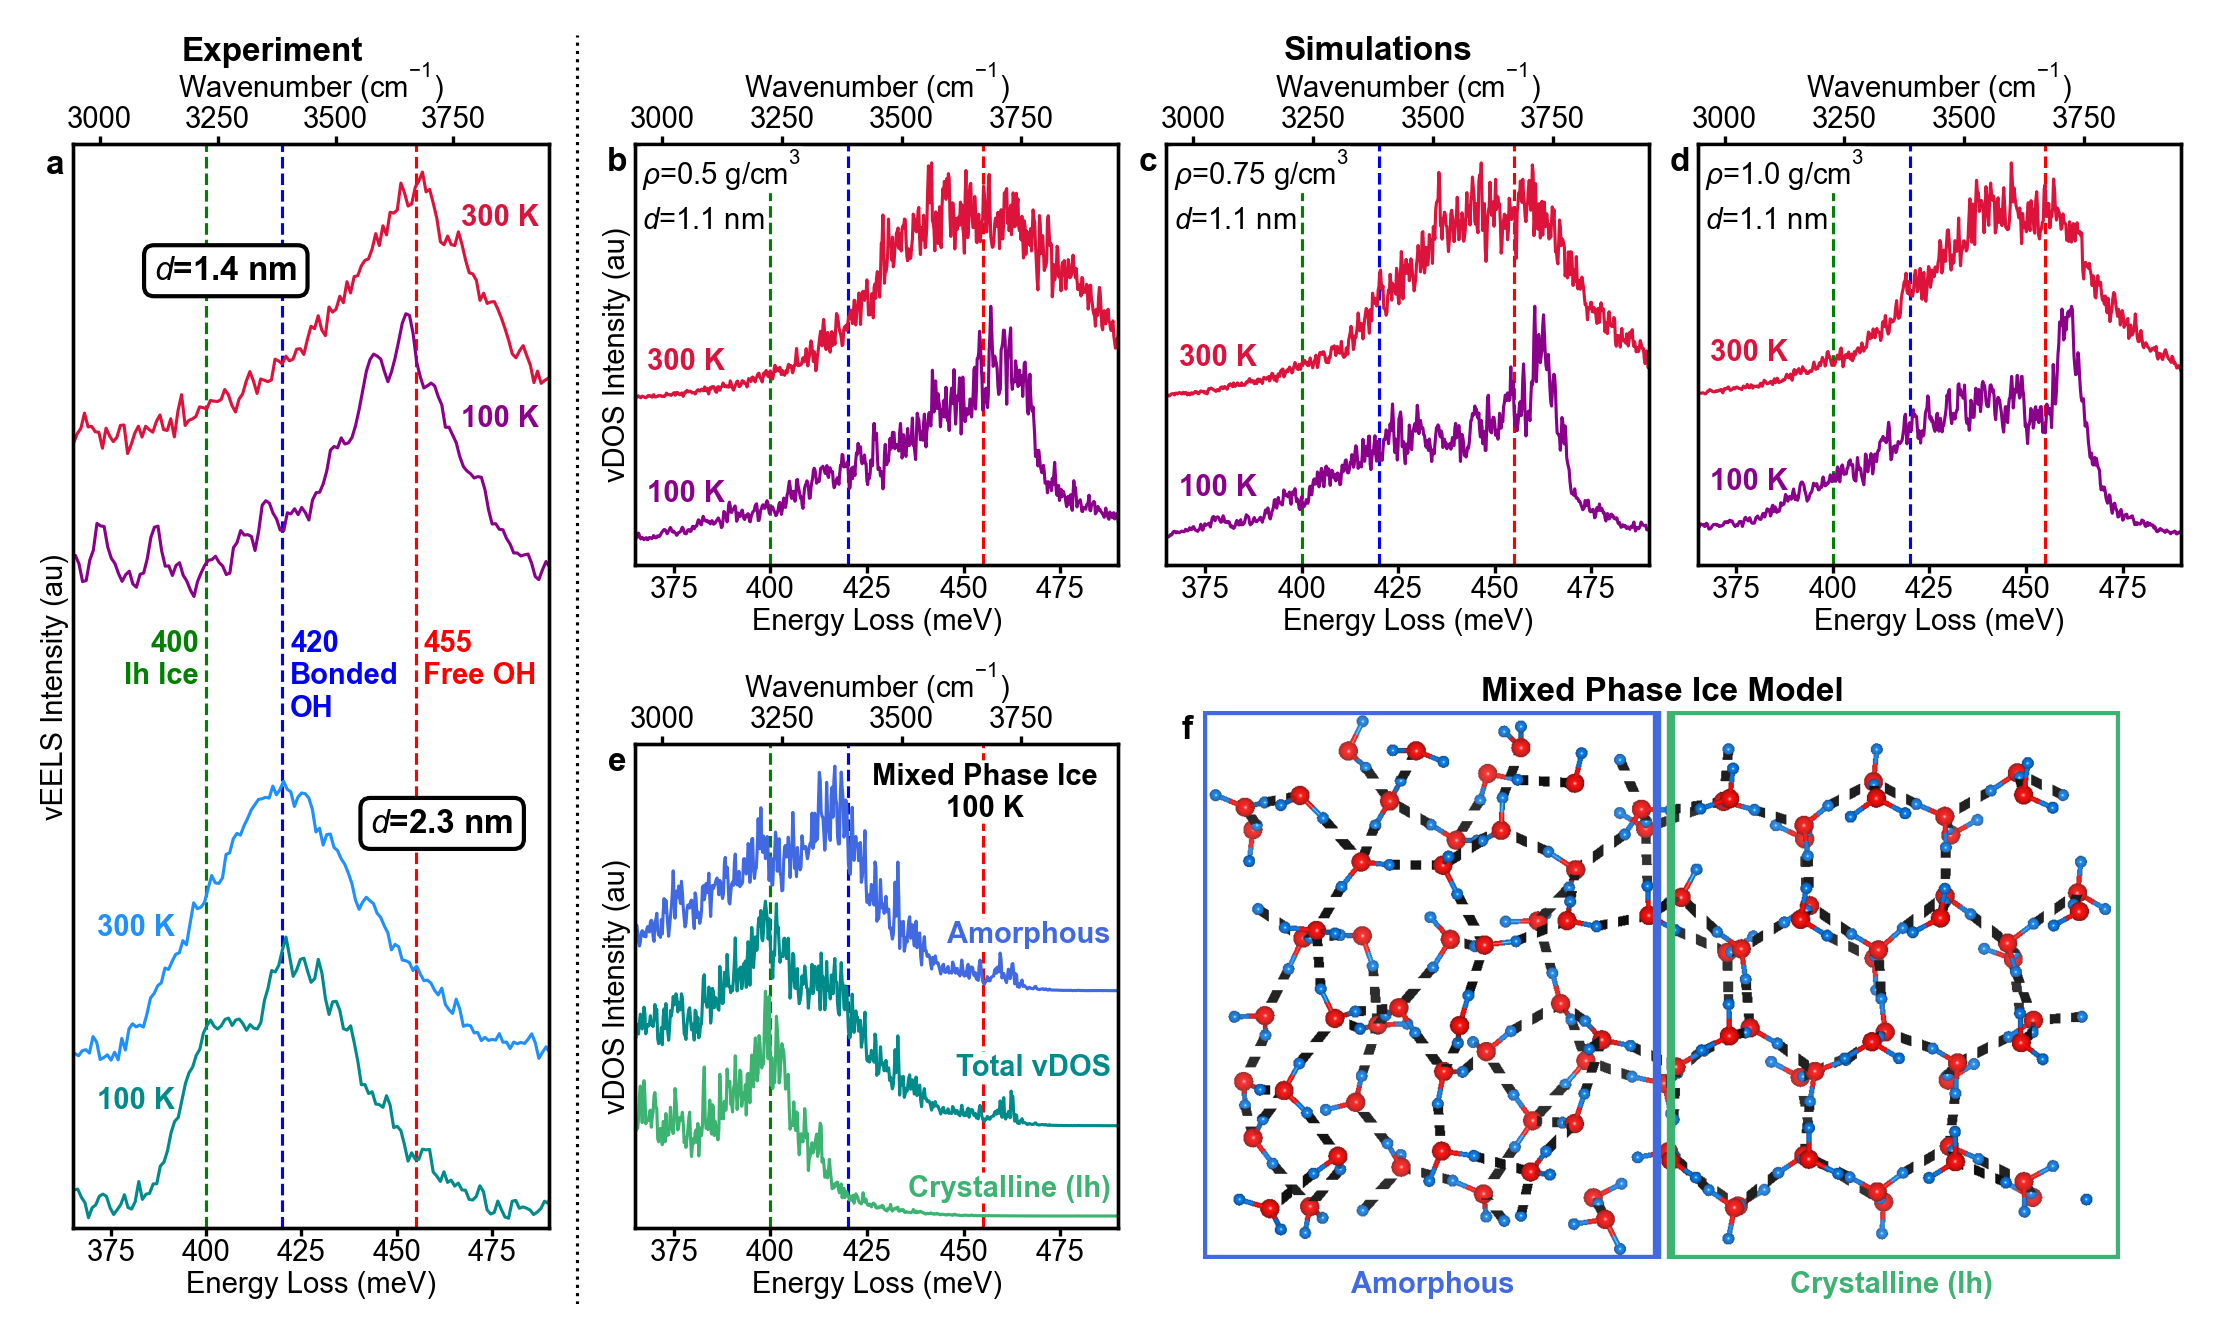

In [10]:
fig=plt.figure(dpi=300,figsize=(183/25.4,4.25))

# Preamble: Experimental and Theoretical Sides of Figure
ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
for spine in ax.spines.values(): spine.set_visible(False)

ax.axvline(0.253,0,0.995,color='k',ls=':')
ax.text(0.07,0.995,'Experiment',fontsize=8,fontweight='bold',ha='left',va='top',color='k',transform=ax.transAxes)
ax.text(0.58,0.995,'Simulations',fontsize=8,fontweight='bold',ha='left',va='top',color='k',transform=ax.transAxes)

# Panel a: vEELS RT and CT
ax_vEELS=fig.add_axes([0.02,0.06,0.22,0.85])
plt.setp(ax_vEELS,xlim=(365,490),ylim=(-0.025,3.8),yticks=[],xlabel='Energy Loss (meV)',ylabel='vEELS Intensity (au)')
ax_vEELS.plot(vEELS_E[0],CNT_F.NormArray(vEELS_S_SG[0])+2.7,lw=0.75,color='Crimson')
ax_vEELS.plot(vEELS_E[1],CNT_F.NormArray(vEELS_S_SG[1])+2.2,lw=0.75,color='DarkMagenta')
ax_vEELS.plot(vEELS_E[2],CNT_F.NormArray(vEELS_S_SG[2])+0.55,lw=0.75,color='DodgerBlue')
ax_vEELS.plot(vEELS_E[3],CNT_F.NormArray(vEELS_S_SG[3]),lw=0.75,color='DarkCyan')

ax_vEELS.axvline(400,color='g',ls='--',zorder=0)
ax_vEELS.text(398,np.mean(ax_vEELS.get_ylim())+0.2,'400\nIh Ice',fontweight='bold',ha='right',va='top',color='g')
ax_vEELS.axvline(420,color='b',ls='--',zorder=0)
ax_vEELS.text(422,np.mean(ax_vEELS.get_ylim())+0.2,'420\nBonded\nOH',fontweight='bold',ha='left',va='top',color='b')
ax_vEELS.axvline(455,color='r',ls='--',zorder=0)
ax_vEELS.text(457,np.mean(ax_vEELS.get_ylim())+0.2,'455\nFree OH',fontweight='bold',ha='left',va='top',color='r')

bbox_dict=dict(boxstyle='round, pad=0.3', facecolor='w', edgecolor='k')
ax_vEELS.text(0.17,0.875,r'$d$=1.4 nm',fontsize=8,bbox=bbox_dict,fontweight='bold',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.815,0.925,'300 K',fontweight='bold',color='Crimson',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.815,0.74,'100 K',fontweight='bold',color='DarkMagenta',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.625,0.365,r'$d$=2.3 nm',fontsize=8,bbox=bbox_dict,fontweight='bold',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.05,0.27,'300 K',fontweight='bold',color='DodgerBlue',transform=ax_vEELS.transAxes)
ax_vEELS.text(0.05,0.11,'100 K',fontweight='bold',color='DarkCyan',transform=ax_vEELS.transAxes)

a2=ax_vEELS.twiny()
a2.set_xticks([3000,3250,3500,3750])
a2.set_xlim(365*8.06554,490*8.06554)
a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

labels=['a','b','c','d','e','f']
label_kwargs={'fontsize':8,'fontweight':'bold','ha':'center','va':'top'}
ax_vEELS.text(-0.0375,0.995,labels.pop(0),transform=ax_vEELS.transAxes,**label_kwargs)

# Panel b-d: vDOS at RT and CT for Water-Filled CNT
gs_vDOS_CNT=plt.GridSpec(ncols=3,nrows=1,hspace=0,wspace=0.1,top=0.91,bottom=0.58,right=0.995,left=0.28)
a_vDOS_CNT=np.asarray([fig.add_subplot(gs_vDOS_CNT[i]) for i in range(3)])
plt.setp(a_vDOS_CNT,xlim=(365,490),yticks=[],xlabel='Energy Loss (meV)')
a_vDOS_CNT[0].plot(vDOS_0pt5_RT_E,CNT_F.NormArray(vDOS_0pt5_RT_S)+0.6,color='Crimson')
a_vDOS_CNT[0].plot(vDOS_0pt5_CT_E,CNT_F.NormArray(vDOS_0pt5_CT_S),color='DarkMagenta')
a_vDOS_CNT[1].plot(vDOS_0pt75_RT_E,CNT_F.NormArray(vDOS_0pt75_RT_S)+0.6,color='Crimson')
a_vDOS_CNT[1].plot(vDOS_0pt75_CT_E,CNT_F.NormArray(vDOS_0pt75_CT_S),color='DarkMagenta')
a_vDOS_CNT[2].plot(vDOS_1pt0_RT_E,CNT_F.NormArray(vDOS_1pt0_RT_S)+0.6,color='Crimson')
a_vDOS_CNT[2].plot(vDOS_1pt0_CT_E,CNT_F.NormArray(vDOS_1pt0_CT_S),color='DarkMagenta')

a_vDOS_CNT[0].set_ylabel('vDOS Intensity (au)')

bbox_dict=dict(boxstyle='round, pad=0.05', facecolor='w', edgecolor='none')
dens=[r'$\rho$=0.5 g/cm$^3$',r'$\rho$=0.75 g/cm$^3$',r'$\rho$=1.0 g/cm$^3$']
for i in range(3):
    a_vDOS_CNT[i].text(-0.0375,0.995,labels.pop(0),transform=a_vDOS_CNT[i].transAxes,**label_kwargs)
    a_vDOS_CNT[i].text(0.015,0.905,dens.pop(0),bbox=bbox_dict,transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.015,0.8,r'$d$=1.1 nm',bbox=bbox_dict,transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.025,0.465+i*0.01,'300 K',fontweight='bold',color='Crimson',transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].text(0.025,0.15+i*0.015,'100 K',fontweight='bold',color='DarkMagenta',transform=a_vDOS_CNT[i].transAxes)
    a_vDOS_CNT[i].axvline(400,color='g',ls='--',zorder=0)
    a_vDOS_CNT[i].axvline(420,color='b',ls='--',zorder=0)
    a_vDOS_CNT[i].axvline(455,color='r',ls='--',zorder=0)
    a2=a_vDOS_CNT[i].twiny()
    a2.set_xlim(365*8.06554,490*8.06554)
    a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

# Panel e: Mixed Phase Ice vDOS
xy=a_vDOS_CNT[0].get_position()
a_vDOS_Ice=fig.add_axes([xy.x0,0.06,xy.width,xy.height*1.15],xlim=(365,490),ylim=(-0.05,2.1),yticks=[]
                        ,xlabel='Energy Loss (meV)',ylabel='vDOS Intensity (au)')
a_vDOS_Ice.plot(vDOS_Ice_Amorphous_E,CNT_F.NormArray(vDOS_Ice_Amorphous_S)+1.0,color='RoyalBlue')
a_vDOS_Ice.plot(vDOS_Ice_Total_E,CNT_F.NormArray(vDOS_Ice_Total_S)+0.4,color='DarkCyan')
a_vDOS_Ice.plot(vDOS_Ice_Crystal_E,CNT_F.NormArray(vDOS_Ice_Crystal_S),color='MediumSeaGreen')

a_vDOS_Ice.text(0.725,0.85,'Mixed Phase Ice\n100 K',fontweight='bold',color='k'
                ,transform=a_vDOS_Ice.transAxes,ha='center',bbox=bbox_dict)

a_vDOS_Ice.text(0.985,0.59,'Amorphous',fontweight='bold',color='RoyalBlue'
                ,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)
a_vDOS_Ice.text(0.985,0.315,'Total vDOS',fontweight='bold',color='DarkCyan'
                ,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)
a_vDOS_Ice.text(0.985,0.065,'Crystalline (Ih)',fontweight='bold',color='MediumSeaGreen'
                ,transform=a_vDOS_Ice.transAxes,ha='right',bbox=bbox_dict)

a_vDOS_Ice.axvline(400,color='g',ls='--',zorder=0)
a_vDOS_Ice.axvline(420,color='b',ls='--',zorder=0)
a_vDOS_Ice.axvline(455,color='r',ls='--',zorder=0)

a2=a_vDOS_Ice.twiny()
a2.set_xlim(365*8.06554,490*8.06554)
a2.set_xlabel(r'Wavenumber (cm$^{-1}$)',labelpad=2)

a_vDOS_Ice.text(-0.0375,0.995,labels.pop(0),transform=a_vDOS_Ice.transAxes,**label_kwargs)

# Panel e: Mixed Phase Ice Snapshot
ax_snapshot=fig.add_axes([0.495,0.035,0.52,0.43],xticks=[],yticks=[])
for spine in ax_snapshot.spines.values(): spine.set_edgecolor('None')
    
ax_snapshot.imshow(Snapshot_Ice)

ax_snapshot.set_title('Mixed Phase Ice Model',y=0.975,fontweight='bold',fontsize=8)
ax_snapshot.add_patch(Rectangle((0.,0),0.495,1,fc='None',ec='RoyalBlue',lw=2,transform=ax_snapshot.transAxes))
ax_snapshot.text(0.25,-0.06,'Amorphous',fontweight='bold',color='RoyalBlue'
                ,transform=ax_snapshot.transAxes,ha='center',bbox=bbox_dict)

ax_snapshot.add_patch(Rectangle((0.51,0.0),0.49,1,fc='None',ec='MediumSeaGreen',lw=2,transform=ax_snapshot.transAxes))
ax_snapshot.text(0.75,-0.06,'Crystalline (Ih)',fontweight='bold',color='MediumSeaGreen'
                ,transform=ax_snapshot.transAxes,ha='center',bbox=bbox_dict)

ax_snapshot.text(-0.0175,0.995,labels.pop(0),transform=ax_snapshot.transAxes,**label_kwargs)